In [1]:
# TODO: 
# 1. split the BTC and ETH data to train, test data
# 2. uploading data to S3 bucket 
# 3. using sagemaker to train the model with the data

In [20]:
import pandas as pd 
data_path = './Data/ETH_merged_with_sentiment_data.csv'
# data_path = './Data/BTC_3hrs_merged_with_sentiment_data.csv'
df = pd.read_csv(data_path, delimiter=',', usecols=['time_period_end', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'sentimentScore'])
df = df.rename(columns={"time_period_end": "Date", "price_open": "Open", "price_high": "High", "price_low": "Low", "price_close": "Close", "volume_traded": "Volume", "sentiment_score": "sentimentScore"})
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume,sentimentScore
14195,2021-04-27T12:00:00.0000000Z,2538.11,2581.70,2534.720,2577.62,38298.192501,NaN
14196,2021-04-27T15:00:00.0000000Z,2576.67,2642.00,2536.405,2637.99,114844.770803,NaN
14197,2021-04-27T18:00:00.0000000Z,2639.60,2683.65,2620.000,2648.42,159363.531665,NaN
14198,2021-04-27T21:00:00.0000000Z,2648.42,2652.31,2604.380,2647.14,62039.467284,NaN
14199,2021-04-28T00:00:00.0000000Z,2647.14,2669.77,2603.040,2667.86,50360.032505,NaN


In [21]:
'''Create indexes to split dataset'''
times = sorted(df.index.values)
print(len(times))
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

14200


In [22]:
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Data normalization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_train[['Open', 'High', 'Low', 'Close']])
df_train[['Volume']] = scaler.fit_transform(df_train[['Volume']])

df_val[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_val[['Open', 'High', 'Low', 'Close']])
df_val[['Volume']] = scaler.fit_transform(df_val[['Volume']])

df_test[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_test[['Open', 'High', 'Low', 'Close']])
df_test[['Volume']] = scaler.fit_transform(df_test[['Volume']])

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11360, 6)
Validation data shape: (1420, 6)
Test data shape: (1420, 6)


/opt/anaconda3/envs/time_series_prediction/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-22-daced0f618a9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_train[['Open', 'High', 'Low', 'Close']])
/opt/anaconda3/envs/time_series_prediction/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

,Open,High,Low,Close,Volume,sentimentScore
0,0.004112,0.003410,0.002669,0.002695,0.000394,0.20
1,0.002685,0.002145,0.002618,0.002334,0.000237,0.20
2,0.002237,0.002145,0.002529,0.002674,0.000066,0.20
3,0.002649,0.002139,0.002529,0.002681,0.000079,0.20
4,0.005994,0.005110,0.006360,0.005931,0.000800,0.28


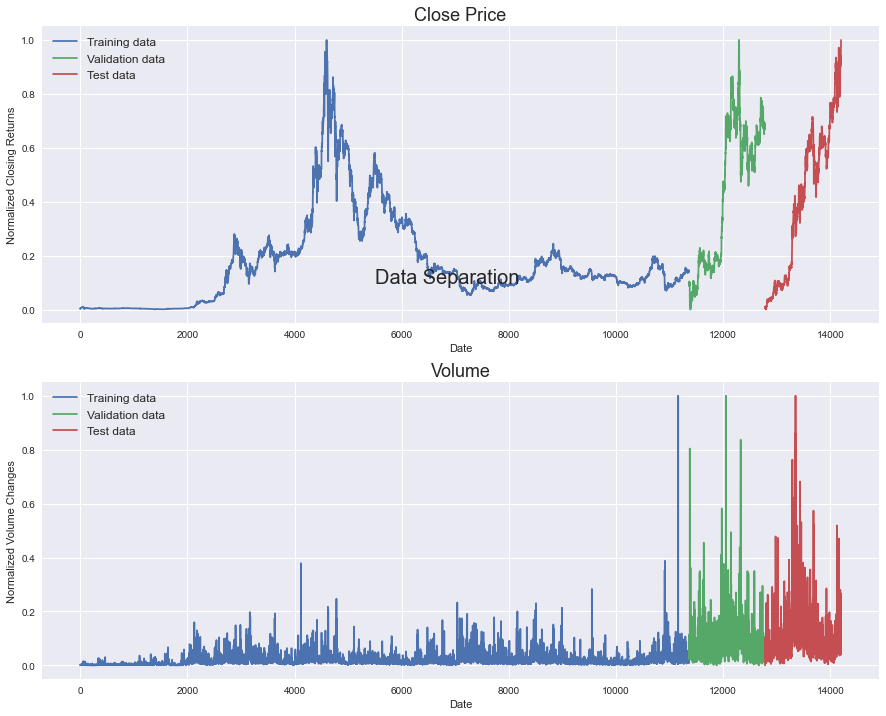

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.6)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [24]:
def save_to_csv(dataframe, file_name):
    dataframe.to_csv(file_name, index=False)  

In [25]:
import boto3, os
def save_to_s3(file_name, upload_file_location, fodler='data', my_bucket='cmajorsolo-transformerbucket',):
    ''' 

    uploading file to AWS S3 bucket 

    '''    
    boto3.Session().resource('s3').Bucket(my_bucket).Object(os.path.join(fodler, file_name)).upload_file(upload_file_location)

In [28]:
# save_to_csv(df_train, './Data/eth_train.csv')
# save_to_csv(df_test, './Data/eth_test.csv')
save_to_csv(df_val, './Data/eth_val.csv')

In [29]:
save_to_s3(file_name='eth_train.csv', upload_file_location='./Data/eth_train.csv')
save_to_s3(file_name='eth_test.csv', upload_file_location='./Data/eth_test.csv')
save_to_s3(file_name='eth_val.csv', upload_file_location='./Data/eth_val.csv')